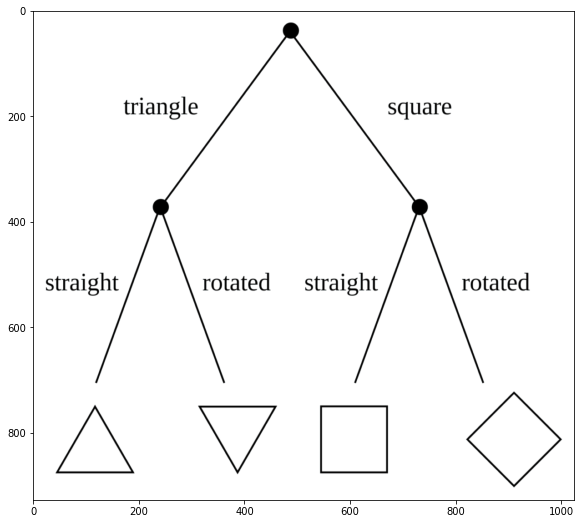

In [1]:
import requests
from io import BytesIO  # buffer for reading data in bytes
from PIL import Image
import matplotlib.pyplot as plt

r = requests.get("https://cdn.corporatefinanceinstitute.com/assets/decision-trees-1024x927.png")

img = Image.open(BytesIO(r.content))
plt.style.use("default")
plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.show()

In [2]:
# Entrophy
# E = - sum(p(X)) * log2(p(X))
# p(X) = number of occurences/total number of samples =  #x / n
#
# Example
# S = [0, 0, 0, 0, 1, 1, 1]
# E = -4/7 * log2(4/7) - 3/7 * log2(3/7) = 0.98 
# (if the result is 1.0 you have equal amount of label values for a given computation)


# Information gain
# IG = E(parent) - [weighted average*E(children)]
#
# Example
# S(parent) = [0, 0, 0, 0, 1, 1, 1],
# Side1 = [0, 0, 0, 0, 1]
# Side2 = [1, 1]
# IG = E(S) - [5/7*E(Side1) + 2/7*E(Side2)]
# IG = 0.98 - [5/7*0.72 + 2/7*0] = 0.46

In [3]:
# Aproach
# Train algorithm := build a tree
#     - start at the top node and at each node select the best split based on the best information gain
#     - greedy search: loop over all features and over all thresholds (all possible feature values)
#     - save the best split feature and split threshold at each node
#     - buil th tree recursively
#     - apply some stopping criteria to stop growing of a tree (maximum depth, minumum samples at node, no more class distribution in node..)
#     - when we ahve a leaf node (last node of a tree), store the most common class label of this node
#
# Predict := Traverse tree
#     - traverse tree recursively
#     - at each node look at the best split feature of the test feator vecore x and go left or right depending on
#         x[feature_idx] <= threshold
#     - when we reachthe leaf node we return the most common sotred classed label

In [4]:
import numpy as np
from collections import Counter

# Entrophy
# E = - sum(p(X)) * log2(p(X))
# p(X) = number of occurences/total number of samples =  #x / n
def entropy(y):
    # number of occurences of all labels, returns [count of label1, ..., count of labeln]
    class_counts = np.bincount(y)
    p_all =  class_counts / len(y)
    return -np.sum([p * np.log2(p) for p in p_all if p > 0])

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_lef_node(self):
        return self.value is not None
    

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
    
    def fit(self, X, y):
        # grow tree
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y)) # get the number of unique elements returned like [0, 1]
        
        # stopping criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        feature_indexes = np.random.choice(n_features, self.n_features, replace=False)
        
        # greedily select the best split according to information gain
        best_feature, best_treshold = self._best_criteria(X, y, feature_indexes)
        
        # grow the children that result from the split
        left_indexes, right_indexes = self._split(X[:, best_feature], best_treshold)
        left = self._grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self._grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        return Node(best_feature, best_treshold, left, right)
        
    def _best_criteria(self, X, y, feature_indexes):
        best_gain = -1
        split_index, split_threshold = None, None
        for feature_index in feature_indexes:
            X_column = X[:, feature_index]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold
        return split_index, split_threshold
    
    def _information_gain(self, y, X_column, split_threshold):
        # parent loss (enthropy)
        parent_entropy = entropy(y)
        
        # generate split
        left_indexes, rights_indexes = self._split(X_column, split_threshold)
        
        if not len(left_indexes) or not len(rights_indexes):
            return 0
        
        # compute the weighted avg. of the loss for the children
        # (weighted average of child entrophy)
        n_samples = len(y)
        n_left_samples, n_right_samples = len(left_indexes), len(rights_indexes)
        entropy_left, entropy_right = entropy(y[left_indexes]), entropy(y[rights_indexes])
        child_entropy = (n_left_samples/n_samples)*entropy_left + (n_right_samples/n_samples)*entropy_right 
        
        # return information gain
        information_gain = parent_entropy - child_entropy
        return information_gain
    
    def _split(self, X_column, split_threshold):
        left_indexes = np.argwhere(X_column <= split_threshold).flatten()
        right_indexes = np.argwhere(X_column >= split_threshold).flatten()
        return left_indexes, right_indexes
        
    
    def predict (self, X):
        # traverse tree
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_lef_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        
        return self._traverse_tree(x, node.right)
    
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [5]:
from data_generation import GenerateDatasets

dataset = GenerateDatasets()
dataset = dataset.make_blobs(nr_blobs=4,
                   nr_samples=1000,
                   nr_cols=2,
                   size_left=1,
                   mode=1.5,
                   size_right=2,
                   scale_row=1,
                   scale_col=1,
                   random_seed=True)
X, y = dataset

In [6]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X[:10], y[:10]

(array([[4.68346726, 2.11968948],
        [4.44011146, 2.77344846],
        [4.66200938, 2.61710026],
        [1.48465725, 1.46943426],
        [1.71737597, 1.46566064],
        [3.54375055, 1.79062764],
        [1.27251922, 1.42454994],
        [3.25317949, 1.85074491],
        [4.3968068 , 2.4319658 ],
        [1.34790507, 1.30378589]]),
 array([3, 3, 3, 0, 0, 2, 0, 2, 3, 0]))

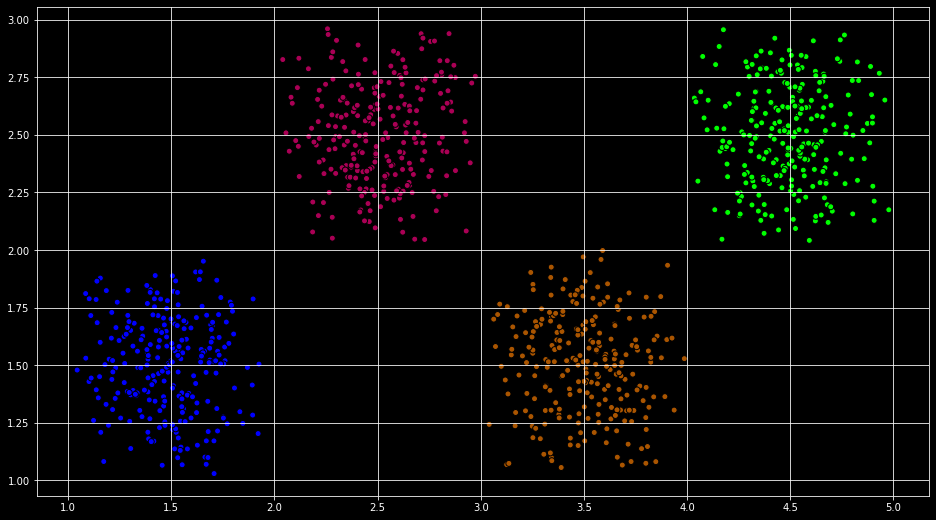

In [8]:
plt.style.use("dark_background")
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg", edgecolors="k")
plt.grid()
plt.show()

In [9]:
tree = DecisionTree(max_depth=1000)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [10]:
# accuracy
sum((y_test==y_pred) / len(y_pred))

1.0000000000000007

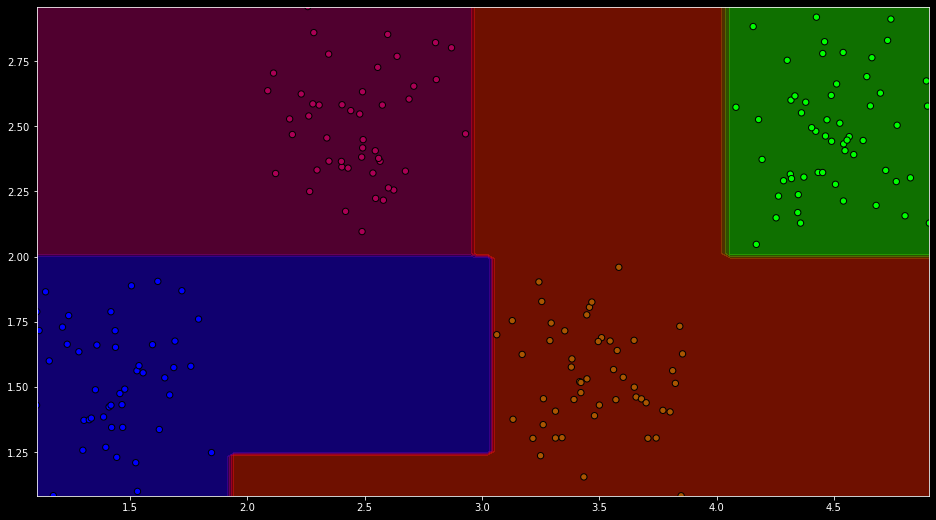

In [11]:
from data_plotting import Plots

plot = Plots()
plot.plot_decision_boundary(tree,
                           X_test,
                           y_test,
                           bound_smoot=100,
                           fig_size=(16, 9),
                           grid=False,
                           verbose=False,
                           cmap="brg")